# Crypto Website API Pull Project

This project pulls data from a crypto website API and puts results in a CSV & DataFrame

## Step 1. Collect Data from Crypto Website

#### Import Modules

In [1]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import os
import pandas as pd
from time import time
from time import sleep
import datetime

#### Hard-Code Variables & Customize DataFrame Display

In [2]:
directory_path = os.getcwd() + "\\"
file_name = 'API.csv'
url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'

# # Original Sandbox Environment
# url = 'https://sandbox-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'

parameters = {
  'start':'1',
  'limit':'15',  # Customize how many cryptos are pulled
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': '0ad53085-1cb2-4eb8-ad9e-3ffbd7e56509',  # Dummy API Key
}

session = Session()

# Display all columns & rows in a DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Build CryptoAPIPuller Class

In [3]:
class CryptoAPIPuller():
    def __init__(self, directory_path, file_name, url, parameters, headers, session):
        self.directory_path = directory_path
        self.file_name = file_name
        self.file_path = f'{self.directory_path}{self.file_name}'
        self.url = url
        self.parameters = parameters
        self.headers = headers
        self.session = session
        self.session_data = None
        self.json_df = None
        self.csv_df = None
    
    def GetJSONData(self):
        self.session.headers.update(self.headers)

        try:
          response = self.session.get(self.url, params=self.parameters)
          self.session_data = json.loads(response.text)
        except (ConnectionError, Timeout, TooManyRedirects) as e:
          print(e)
    
    def JSONToDataFrame(self):
        self.json_df = pd.json_normalize(self.session_data['data'])
        self.json_df['timestamp'] = pd.to_datetime('now')
    
    def AddDataFrameToCSV(self):
        if not os.path.isfile(self.file_path):
            self.json_df.to_csv(self.file_path, header='column_names')
        else:
            self.json_df.to_csv(self.file_path, mode='a', header=False)
    
    def CSVToDataFrame(self):
        self.csv_df = pd.read_csv(self.file_path)
        return self.csv_df
    
    def DropCSV(self):
        if os.path.exists(self.file_name):
            os.remove(self.file_name)
            return True
        else:
            return False

    def APIRunner(self, count=False):
        self.GetJSONData()
        self.JSONToDataFrame()
        self.AddDataFrameToCSV()
        self.CSVToDataFrame()
        
        if count:
            print(f"Count: {count} | ",end='')
        print(f"{datetime.datetime.now()} | API Runner Completed Successfully")        
    
    def AutoAPIRunner(self, counter=333, interval_sec=60, drop_csv=False):
        if drop_csv:
            self.DropCSV()
        for count in range(1, counter+1):
            if count > 1:
                sleep(interval_sec)  # Wait for n seconds
            self.APIRunner(count)

#### Initialize CryptoAPIPuller & Run AutoAPIRunner Method

In [4]:
pull = CryptoAPIPuller(directory_path, file_name, url, parameters, headers, session)
pull.AutoAPIRunner(counter=5, interval_sec=60, drop_csv=True)

Count: 1 | 2024-05-04 18:16:04.864875 | API Runner Completed Successfully
Count: 2 | 2024-05-04 18:17:05.184301 | API Runner Completed Successfully
Count: 3 | 2024-05-04 18:18:05.472944 | API Runner Completed Successfully
Count: 4 | 2024-05-04 18:19:05.753608 | API Runner Completed Successfully
Count: 5 | 2024-05-04 18:20:05.931432 | API Runner Completed Successfully


## Step 2. Analyze, Clean, & Visualize Crypto Data

#### Write Functions to Clean, Analyze, & Visualize the CryptoAPIPuller's AutoAPIRunner DataFrame

In [5]:
# import module(s)
import seaborn as sns
import matplotlib.pyplot as plt

# Get DataFrame created from CryptoAPIPuller's AutoAPIRunner Method
df = pull.csv_df

# Float decimal places used by FormatFloats function
decimal_place=5

# Crypto to Query when using CryptoQuery function
crypto = 'Bitcoin'

# These three variables will be used by ReplaceDataFrameValues function
columns_to_update = ['percent_change']
old_column_values = [
    'quote.USD.percent_change_1h',
    'quote.USD.percent_change_24h',
    'quote.USD.percent_change_7d',
    'quote.USD.percent_change_30d',
    'quote.USD.percent_change_60d',
    'quote.USD.percent_change_90d']
new_column_values = ['1h','24h','7d','30d','60d','90d']

# functions to clean & view data
def FormatFloats(df):
    float_number = f"%.{decimal_place}f"
    pd.set_option('display.float_format', lambda x: float_number % x)
    return df

def CryptoQuery(df, Crypto='Bitcoin'):
    df_query = df[['name','quote.USD.price','timestamp']]
    df_query = df_query.query(f"name == '{Crypto}'")
    return df_query

def GroupByMean(df):
    group_by_column = ['name']

    value_columns = [
        'quote.USD.percent_change_1h',
        'quote.USD.percent_change_24h',
        'quote.USD.percent_change_7d',
        'quote.USD.percent_change_30d',
        'quote.USD.percent_change_60d',
        'quote.USD.percent_change_90d'
    ]
    
    df_group = df.groupby(group_by_column, sort=False)[value_columns].mean()
    return df_group

def DataFrameToStack(df):
    df_stack = df.stack()  # Makes stack (type: series) from a dataframe
    return df_stack

def StackToDataFrame(df):
    stack_df = df.to_frame(name='values')  # Return from series stack to dataframe
    return stack_df

def ResetDataFrameIndex(df):
    index = pd.Index(range(int(df.count().sum())))  # Build range index using DataFrame value count
    df_reset_index = df.reset_index().rename(columns={'level_1': 'percent_change'})  # Correct column name change
    return df_reset_index

def ReplaceDataFrameValues(df, columns, old_values, new_values):
    df_relabed = df
    df_relabed[columns] = df_relabed[columns].replace(old_values,new_values)
    return df_relabed

def CreateCategoricalPlot(df):
    sns.catplot(x='percent_change', y='values', hue='name', data=df, kind='point')

# Analysis & query
FormatFloats(df)  # See entire dataframe
query = CryptoQuery(df, crypto)  # Queries one type of cryptocurrency

# DataFrame transform for visualization
df1 = GroupByMean(df)  # groups by column(s), then aggregates values (mean)
df2 = DataFrameToStack(df1)  # 'transpose' dataframe by converting it to a stack
df3 = StackToDataFrame(df2)  # Convert the stack back to a dataframe for further processing
df4 = ResetDataFrameIndex(df3)  # Resets dataframe index
df5 = ReplaceDataFrameValues(df4, columns_to_update, old_column_values,new_column_values)  #clean

#### Review Each Step & Final Visualization

Note: When using the cell below, comment/uncomment the variables to see a 'snapshot' during the viewing/cleaning process. If multiple variables are uncommented, then the latest variable will be shown below.

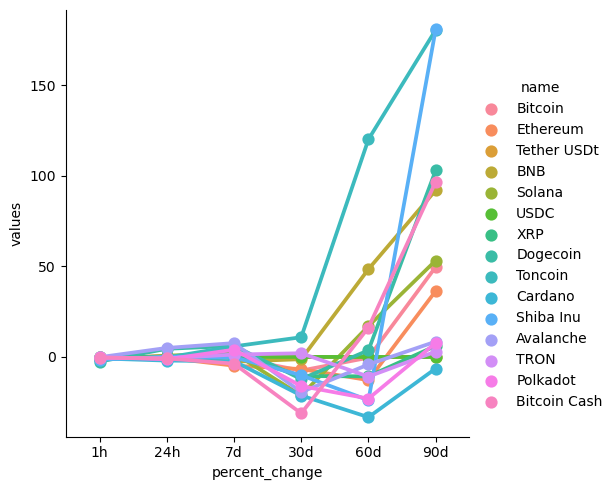

In [6]:
# Analysis & query
df  # See entire dataframe
query  # Queries one type of cryptocurrency

# DataFrame transform for visualization (steps)
df1  # step 1: groups by column(s), then aggregates values (mean)
df2  # step 2: 'transpose' dataframe by converting it to a stack
df3  # step 3: Convert the stack back to a dataframe for further processing
df4  # step 4: Resets dataframe index from a column to a default index
df5  # step 5: Clean column by replacing characters in the column's values
CreateCategoricalPlot(df5)  # step 6: view results in a categorical plot